### Minh Vo
### ADSP 32009 - Data Science in Healthcare (Autumn 23)
### Project 2 - Cancer Survival Analysis


Columns denote different types of cancer.

Columns ending with _DT are the dates of cancer diagnosis.

For each column, a 1 (or 0) indicates patient has (does not have) that type of cancer.

**Calculate the age of each patient at the time of cancer diagnosis.**

**Analyze survival rate by gender, race and age group in deciles (11-20, 21-30, ....) for patients with following cancer:**

- lung
- pancreas
- thyroid
- colorectal
- melanoma


Note:

1. Use 8/25/16 as the end date of the analysis.

2. Remove all diagnosis after 8/25/16.

3. Keep patients who died after 8/25/16 (you need to censor this data).

4. Remove all patients who do not have a diagnosis date.

5. Categorize race into White, African-American, Asian/Mideast-Indian, and Others.

6. Patients with more than 1 cancer - treat them as independent data points for each cancer type

In [478]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import pairwise_logrank_test

### Data Loading

In [479]:
df = pd.read_excel("Cancer_patient_data.xlsx")

print(df.shape)
df.head()

(8468, 14)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
3,1932-07-28,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT


In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8468 entries, 0 to 8467
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  8468 non-null   datetime64[ns]
 1   DEATH_DATE_off  447 non-null    datetime64[ns]
 2   sex             8468 non-null   object        
 3   race            8466 non-null   object        
 4   LUNG            8468 non-null   int64         
 5   PANCREAS        8468 non-null   int64         
 6   THYROID         8468 non-null   int64         
 7   COLORECTAL      8468 non-null   int64         
 8   MELANOMA        8468 non-null   int64         
 9   LUNG DT         1485 non-null   datetime64[ns]
 10  PANCREAS_DT     660 non-null    datetime64[ns]
 11  THYROID_DT      745 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
dtypes: datetime64[ns](7), int64(5), object(2)
memory usage: 

In [481]:
df = df.rename(columns = {"LUNG DT": "LUNG_DT"})
df.columns

Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'LUNG', 'PANCREAS',
       'THYROID', 'COLORECTAL', 'MELANOMA', 'LUNG_DT', 'PANCREAS_DT',
       'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT'],
      dtype='object')

In [482]:
df.race.value_counts()

race
White                                     5725
Black/African-American                    2071
Unknown                                    253
Asian/Mideast Indian                       234
More than one Race                          90
Patient Declined                            50
Native Hawaiian/Other Pacific Islander      30
American Indian or Alaska Native            13
Name: count, dtype: int64

### Data Proprocesing

In [483]:
diagnosis_dt = ['LUNG_DT', 'PANCREAS_DT', 'THYROID_DT', 'COLORECTAL_DT', 'MELANOMA_DT']
cancer_types = ['LUNG', 'PANCREAS', 'THYROID', 'COLORECTAL', 'MELANOMA']

#### Categorize race into White, African-American, Asian/Mideast-Indian, and Others.

In [484]:
def categorize_race(race):
    if pd.isna(race):
        return 'Others'
    elif race == 'White':
        return 'White'
    elif race == 'Black/African-American':
        return 'African-American'
    elif race == 'Asian/Mideast Indian':
        return 'Asian/Mideast-Indian'
    else:
        return 'Others'

df['race'] = df['race'].apply(categorize_race)
df['race'].value_counts()


race
White                   5725
African-American        2071
Others                   438
Asian/Mideast-Indian     234
Name: count, dtype: int64

In [485]:
# # Function to calculate age at diagnosis
# def calculate_age_at_diagnosis(row):
#     for cancer_type in cancer_types:
#         diagnosis_date = row[cancer_type + '_DT']
#         if pd.notnull(diagnosis_date):  # Check if the diagnosis date is not NaN
#             birth_date = row['BIRTH_DATE_off']
#             # Calculate age at diagnosis using relativedelta
#             age_at_diagnosis = relativedelta(diagnosis_date, birth_date).years
#             return age_at_diagnosis
#     return None

In [486]:
# # Apply the function to create the "Age_at_diagnosis" column
# df['AGE_AT_DIAGNOSIS'] = df.apply(calculate_age_at_diagnosis, axis=1)
# df['AGE_AT_DIAGNOSIS'] = df['AGE_AT_DIAGNOSIS'].round(1)

# # Check the result
# df[df["LUNG"]==1]

#### Remove all patients who do not have a diagnosis date

In [487]:
# df[df["AGE_AT_DIAGNOSIS"].isnull()]

In [488]:
# Although these patients were diagnosis with cancer, they did not have the diagnosis date.
# df = df.dropna(subset = "AGE_AT_DIAGNOSIS")
# df["AGE_AT_DIAGNOSIS"].isna().sum()

In [489]:
# Check if all diagnosis date columns are NaN
no_diagnosis_mask = df[diagnosis_dt].isnull().all(axis=1)

# Retrieve patients without a diagnosis date for any cancer type
patients_without_diagnosis = df[no_diagnosis_mask]
patients_without_diagnosis

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
3,1932-07-28,NaT,Female,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
5,1950-08-20,NaT,Female,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8,1947-02-27,NaT,Female,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
10,1954-02-12,NaT,Female,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,1959-06-30,NaT,Female,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8461,1956-12-07,NaT,Male,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8462,1952-06-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8464,1938-07-05,NaT,Female,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT


In [490]:
patients_without_diagnosis[patients_without_diagnosis[cancer_types].sum(axis=1) > 0]

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
4330,1963-08-30,NaT,Male,Asian/Mideast-Indian,0,0,0,1,0,NaT,NaT,NaT,NaT,NaT
5911,1953-04-12,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,NaT
7831,1966-03-13,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,NaT
8238,1959-08-20,NaT,Female,African-American,0,0,0,1,0,NaT,NaT,NaT,NaT,NaT


In [491]:
# Remove patients without diagnosis date from the data
df = df[~df.index.isin(patients_without_diagnosis.index)]

print(df.shape)
df.head()

(4153, 14)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,1959-12-02,NaT,Male,African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT
6,1946-11-03,NaT,Female,African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT
7,1938-06-10,NaT,Female,African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT


In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4153 entries, 0 to 8467
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  4153 non-null   datetime64[ns]
 1   DEATH_DATE_off  326 non-null    datetime64[ns]
 2   sex             4153 non-null   object        
 3   race            4153 non-null   object        
 4   LUNG            4153 non-null   int64         
 5   PANCREAS        4153 non-null   int64         
 6   THYROID         4153 non-null   int64         
 7   COLORECTAL      4153 non-null   int64         
 8   MELANOMA        4153 non-null   int64         
 9   LUNG_DT         1485 non-null   datetime64[ns]
 10  PANCREAS_DT     660 non-null    datetime64[ns]
 11  THYROID_DT      745 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
dtypes: datetime64[ns](7), int64(5), object(2)
memory usage: 486.7

In [493]:
df.isna().sum()

BIRTH_DATE_off       0
DEATH_DATE_off    3827
sex                  0
race                 0
LUNG                 0
PANCREAS             0
THYROID              0
COLORECTAL           0
MELANOMA             0
LUNG_DT           2668
PANCREAS_DT       3493
THYROID_DT        3408
COLORECTAL_DT     3207
MELANOMA_DT       3807
dtype: int64

#### Use 8/25/16 as the end date of the analysis. Remove all diagnosis after 8/25/16.

In [494]:
end_date = pd.to_datetime('2016-08-25')

In [495]:
print(f'Lung Date of Diagnosis ranges from {df["LUNG_DT"].min()} to {df["LUNG_DT"].max()}')
print(f'Pancreas Date of Diagnosis ranges from {df["PANCREAS_DT"].min()} to {df["PANCREAS_DT"].max()}')
print(f'Thyroid Date of Diagnosis ranges from {df["THYROID_DT"].min()} to {df["THYROID_DT"].max()}')
print(f'Colorectal Date of Diagnosis ranges from {df["COLORECTAL_DT"].min()} to {df["COLORECTAL_DT"].max()}')
print(f'Melanoma Date of Diagnosis ranges from {df["MELANOMA_DT"].min()} to {df["MELANOMA_DT"].max()}')

Lung Date of Diagnosis ranges from 1999-12-16 00:00:00 to 2016-09-05 00:00:00
Pancreas Date of Diagnosis ranges from 2008-09-26 00:00:00 to 2016-09-04 00:00:00
Thyroid Date of Diagnosis ranges from 1960-01-27 00:00:00 to 2016-09-26 00:00:00
Colorectal Date of Diagnosis ranges from 1999-12-05 00:00:00 to 2016-07-23 00:00:00
Melanoma Date of Diagnosis ranges from 1986-06-02 00:00:00 to 2016-07-27 00:00:00


In [496]:
# Check if any of the diagnosis dates occur after the end date
diagnosis_after_end_date = df[diagnosis_dt] > end_date

# Check if any row has a diagnosis date after the end date
has_diagnosis_after_end_date = diagnosis_after_end_date.any(axis=1)
len(has_diagnosis_after_end_date)

4153

In [497]:
# Remove all diagnosis after end date
df2 = df[~has_diagnosis_after_end_date]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4148 entries, 0 to 8467
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  4148 non-null   datetime64[ns]
 1   DEATH_DATE_off  326 non-null    datetime64[ns]
 2   sex             4148 non-null   object        
 3   race            4148 non-null   object        
 4   LUNG            4148 non-null   int64         
 5   PANCREAS        4148 non-null   int64         
 6   THYROID         4148 non-null   int64         
 7   COLORECTAL      4148 non-null   int64         
 8   MELANOMA        4148 non-null   int64         
 9   LUNG_DT         1483 non-null   datetime64[ns]
 10  PANCREAS_DT     658 non-null    datetime64[ns]
 11  THYROID_DT      744 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
dtypes: datetime64[ns](7), int64(5), object(2)
memory usage: 486.1

In [498]:
df2.isna().sum()

BIRTH_DATE_off       0
DEATH_DATE_off    3822
sex                  0
race                 0
LUNG                 0
PANCREAS             0
THYROID              0
COLORECTAL           0
MELANOMA             0
LUNG_DT           2665
PANCREAS_DT       3490
THYROID_DT        3404
COLORECTAL_DT     3202
MELANOMA_DT       3802
dtype: int64

In [499]:
print(f'Lung Date of Diagnosis ranges from {df2["LUNG_DT"].min()} to {df2["LUNG_DT"].max()}')
print(f'Pancreas Date of Diagnosis ranges from {df2["PANCREAS_DT"].min()} to {df2["PANCREAS_DT"].max()}')
print(f'Thyroid Date of Diagnosis ranges from {df2["THYROID_DT"].min()} to {df2["THYROID_DT"].max()}')
print(f'Colorectal Date of Diagnosis ranges from {df2["COLORECTAL_DT"].min()} to {df2["COLORECTAL_DT"].max()}')
print(f'Melanoma Date of Diagnosis ranges from {df2["MELANOMA_DT"].min()} to {df2["MELANOMA_DT"].max()}')

Lung Date of Diagnosis ranges from 1999-12-16 00:00:00 to 2016-08-11 00:00:00
Pancreas Date of Diagnosis ranges from 2008-09-26 00:00:00 to 2016-08-17 00:00:00
Thyroid Date of Diagnosis ranges from 1960-01-27 00:00:00 to 2016-08-25 00:00:00
Colorectal Date of Diagnosis ranges from 1999-12-05 00:00:00 to 2016-07-23 00:00:00
Melanoma Date of Diagnosis ranges from 1986-06-02 00:00:00 to 2016-07-27 00:00:00


#### Keep patients who died after 8/25/16 (you need to censor this data).

In [500]:
print(f'Patient death date range: {df2["DEATH_DATE_off"].min()} to {df2["DEATH_DATE_off"].max()}')

Patient death date range: 2012-01-16 00:00:00 to 2017-04-28 00:00:00


In [501]:
# Check if any patients' death dates occur after the end date

death_before_end_date = df2[df2["DEATH_DATE_off"] < end_date].any(axis=1)
len(death_before_end_date)

C:\Users\nhoxh\AppData\Local\Temp\ipykernel_5692\1236410419.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  death_before_end_date = df2[df2["DEATH_DATE_off"] < end_date].any(axis=1)


297

Censoring Indicator (using "Death_Date_off" column):
- 1 indicates that the event of interest has occurred (the patient has died).
- 0 indicates that the data is censored (the patient was still alive or died after the end date).

In [502]:
# Create a STATUS column where 1 indicates death and 0 indicates censored
df2['status'] = 1  # Default to death

# Patients who died after the end date are censored
df2.loc[df2['DEATH_DATE_off'] > end_date, 'status'] = 0

# Patients who are still alive are censored
df2.loc[df2['DEATH_DATE_off'].isnull(), 'status'] = 0

df2['status'].value_counts()

C:\Users\nhoxh\AppData\Local\Temp\ipykernel_5692\2356388387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'] = 1  # Default to death


status
0    3851
1     297
Name: count, dtype: int64

In [503]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4148 entries, 0 to 8467
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  4148 non-null   datetime64[ns]
 1   DEATH_DATE_off  326 non-null    datetime64[ns]
 2   sex             4148 non-null   object        
 3   race            4148 non-null   object        
 4   LUNG            4148 non-null   int64         
 5   PANCREAS        4148 non-null   int64         
 6   THYROID         4148 non-null   int64         
 7   COLORECTAL      4148 non-null   int64         
 8   MELANOMA        4148 non-null   int64         
 9   LUNG_DT         1483 non-null   datetime64[ns]
 10  PANCREAS_DT     658 non-null    datetime64[ns]
 11  THYROID_DT      744 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
 14  status          4148 non-null   int64         
dtypes: dateti

#### Create age group column

In [504]:
# sns.histplot(df2["AGE_AT_DIAGNOSIS"])

In [505]:
# # Define the bins for the age groups
# age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
# # Define the labels for the age groups
# age_labels = ['0-10','11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100','>100']

# # Create the AGE_GROUP column
# df2['AGE_GROUP'] = pd.cut(df2['AGE_AT_DIAGNOSIS'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)
# df2['AGE_GROUP'].value_counts()

In [506]:
print(df2.shape)
df2.head()

(4148, 15)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,status
0,1959-12-02,NaT,Male,African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,0
1,1955-11-18,2016-04-20,Male,African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,1
2,1946-01-14,2015-05-25,Female,African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,1
6,1946-11-03,NaT,Female,African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,0
7,1938-06-10,NaT,Female,African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,0


Check duplicates

In [507]:
print("Total duplicates:",df2.duplicated().sum())
df2.loc[df2.duplicated]

Total duplicates: 0


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,status


Check if there are any patients with more than 1 cancer

In [508]:
# Check if there are any patients with more than 1 cancer
df2['num_cancers'] = df2[cancer_types].sum(axis=1)
multi_cancer_patients = df2[df2['num_cancers'] > 1]

print(f'There are {len(multi_cancer_patients)} patients diagnosed with more than 1 cancer')
multi_cancer_patients.head()

There are 29 patients diagnosed with more than 1 cancer


C:\Users\nhoxh\AppData\Local\Temp\ipykernel_5692\1927499697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['num_cancers'] = df2[cancer_types].sum(axis=1)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,status,num_cancers
41,1928-03-25,NaT,Female,African-American,1,0,0,1,0,2012-02-22,NaT,NaT,2013-12-11,NaT,0,2
164,1924-11-30,NaT,Female,African-American,1,0,0,1,0,2013-02-04,NaT,NaT,2013-01-14,NaT,0,2
308,1954-04-20,NaT,Female,African-American,0,0,1,1,0,NaT,NaT,2015-05-06,2010-12-04,NaT,0,2
557,1942-11-10,NaT,Female,White,1,0,0,1,0,2013-09-14,NaT,NaT,2013-08-16,NaT,0,2
611,1955-03-23,NaT,Male,White,0,1,0,0,1,NaT,2014-02-14,NaT,NaT,2013-12-13,0,2


#### Create 5 separate dataframes for each cancer type

In [509]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4148 entries, 0 to 8467
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  4148 non-null   datetime64[ns]
 1   DEATH_DATE_off  326 non-null    datetime64[ns]
 2   sex             4148 non-null   object        
 3   race            4148 non-null   object        
 4   LUNG            4148 non-null   int64         
 5   PANCREAS        4148 non-null   int64         
 6   THYROID         4148 non-null   int64         
 7   COLORECTAL      4148 non-null   int64         
 8   MELANOMA        4148 non-null   int64         
 9   LUNG_DT         1483 non-null   datetime64[ns]
 10  PANCREAS_DT     658 non-null    datetime64[ns]
 11  THYROID_DT      744 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
 14  status          4148 non-null   int64         
 15  num_cance

In [510]:
# Dictionary to store datasets for each cancer type
cancer_df = {}

# For creating AGE_GROUP column
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
age_labels = ['0-10','11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100','>100']

for cancer in cancer_types:
    cols_to_keep = [
        'BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race', 'status', 'num_cancers', cancer, f'{cancer}_DT'
    ]
    # Filter by patients diagnosed with that particular cancer
    temp_df = df2[df2[cancer] == 1][cols_to_keep].copy()

    # Calculate the age of each patient at the time of cancer diagnosis.
    temp_df['AGE_AT_DIAGNOSIS'] = temp_df.apply(lambda row: relativedelta(row[f'{cancer}_DT'], row['BIRTH_DATE_off']).years, axis=1)

    # Categorize each patient into age groups
    temp_df['AGE_GROUP'] = pd.cut(temp_df['AGE_AT_DIAGNOSIS'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

    # Create 'DURATION' column: time from diagnosis to event/censoring
    temp_df['DURATION'] = (temp_df['DEATH_DATE_off'].fillna(end_date) - temp_df[f'{cancer}_DT']).dt.days

    cancer_df[cancer] = temp_df

In [511]:
# Create 5 separate dataframes for each cancer type
lung_df = cancer_df["LUNG"]
pancreas_df = cancer_df["PANCREAS"]
thyroid_df = cancer_df["THYROID"]
colorectal_df = cancer_df["COLORECTAL"]
melanoma_df = cancer_df["MELANOMA"]

### Survival Analysis

In [512]:
# Kaplan-Meier estimator
kmf = KaplanMeierFitter()

In [513]:
# function for plotting survival by groups

def plot_survival(df, group_by):

    for group in df[group_by].unique():
        group_data = df[df[group_by] == group]
        T = group_data['DURATION']
        E = group_data['status']

        kmf = KaplanMeierFitter()           
        kmf.fit(T, E, label=str(group))
        kmf.plot_survival_function()

        plt.title(f"Survival curves by {group_by}")
        plt.xlabel("Days since Diagnosis")
        plt.ylabel("Survival Probability")



In [514]:
def calculate_survival(df, group_by, subgroup, time_point):
    subgroup_data = df[df[group_by] == subgroup]
    
    # Duration and event columns
    T = subgroup_data['DURATION']
    E = subgroup_data['status']
    
    # Fit the Kaplan-Meier model
    kmf = KaplanMeierFitter()
    kmf.fit(T, E)
    
    # Predict the survival probability at the specified time point
    survival_probability = kmf.predict(time_point)
    
    return survival_probability

#### LUNG

In [515]:
print(lung_df.shape)
lung_df.head()

(1483, 11)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,status,num_cancers,LUNG,LUNG_DT,AGE_AT_DIAGNOSIS,AGE_GROUP,DURATION
0,1959-12-02,NaT,Male,African-American,0,1,1,2013-09-01,53,51-60,1089
1,1955-11-18,2016-04-20,Male,African-American,1,1,1,2016-04-02,60,61-70,18
2,1946-01-14,2015-05-25,Female,African-American,1,1,1,2015-04-11,69,61-70,44
9,1957-10-18,NaT,Male,African-American,0,1,1,2012-11-29,55,51-60,1365
12,1940-02-04,NaT,Male,African-American,0,1,1,2013-05-21,73,71-80,1192


In [516]:
lung_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1483 entries, 0 to 8446
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    1483 non-null   datetime64[ns]
 1   DEATH_DATE_off    196 non-null    datetime64[ns]
 2   sex               1483 non-null   object        
 3   race              1483 non-null   object        
 4   status            1483 non-null   int64         
 5   num_cancers       1483 non-null   int64         
 6   LUNG              1483 non-null   int64         
 7   LUNG_DT           1483 non-null   datetime64[ns]
 8   AGE_AT_DIAGNOSIS  1483 non-null   int64         
 9   AGE_GROUP         1483 non-null   category      
 10  DURATION          1483 non-null   int64         
dtypes: category(1), datetime64[ns](3), int64(5), object(2)
memory usage: 129.3+ KB


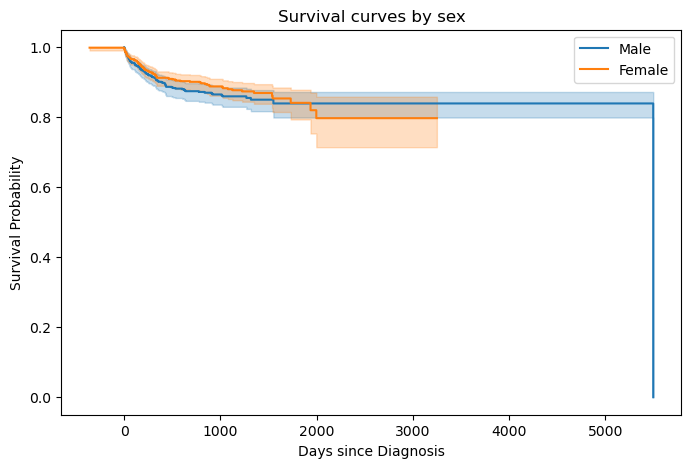

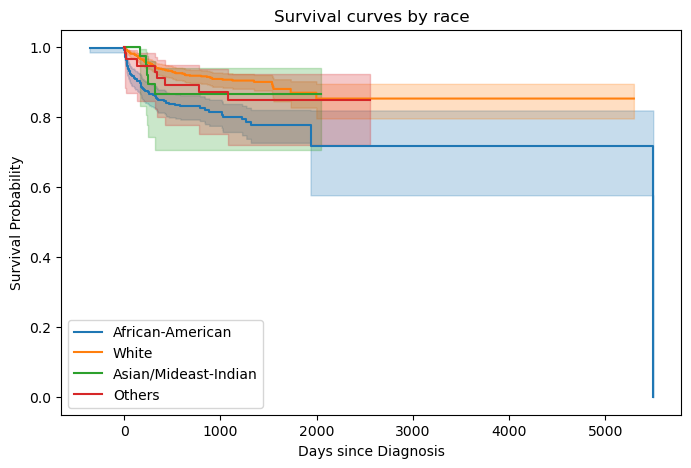

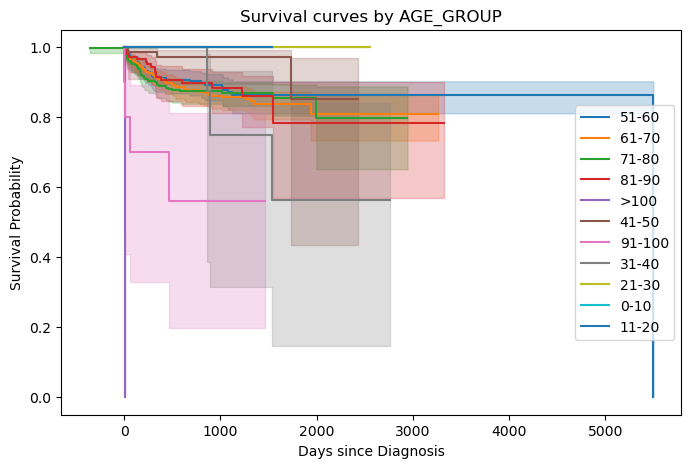

In [517]:
# Survival curves by gender
plt.figure(figsize=(8,5))
plot_survival(lung_df, 'sex')
plt.show()

# Survival curves by race
plt.figure(figsize=(8,5))
plot_survival(lung_df, 'race')
plt.show()

# Survival curves by age group
plt.figure(figsize=(8,5))
plot_survival(lung_df, 'AGE_GROUP')
plt.show()

#### PANCREAS

In [518]:
print(pancreas_df.shape)
pancreas_df.head()

(658, 11)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,status,num_cancers,PANCREAS,PANCREAS_DT,AGE_AT_DIAGNOSIS,AGE_GROUP,DURATION
44,1955-03-10,2012-11-22,Female,African-American,1,1,1,2012-10-12,57,51-60,41
55,1929-06-27,NaT,Female,African-American,0,1,1,2016-01-27,86,81-90,211
57,1938-06-24,NaT,Male,White,0,1,1,2013-11-19,75,71-80,1010
92,1952-08-30,2016-11-21,Male,African-American,0,1,1,2014-10-27,62,61-70,756
118,1956-07-15,2016-04-22,Male,African-American,1,1,1,2016-03-13,59,51-60,40


In [519]:
pancreas_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 658 entries, 44 to 8420
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    658 non-null    datetime64[ns]
 1   DEATH_DATE_off    44 non-null     datetime64[ns]
 2   sex               658 non-null    object        
 3   race              658 non-null    object        
 4   status            658 non-null    int64         
 5   num_cancers       658 non-null    int64         
 6   PANCREAS          658 non-null    int64         
 7   PANCREAS_DT       658 non-null    datetime64[ns]
 8   AGE_AT_DIAGNOSIS  658 non-null    int64         
 9   AGE_GROUP         658 non-null    category      
 10  DURATION          658 non-null    int64         
dtypes: category(1), datetime64[ns](3), int64(5), object(2)
memory usage: 57.6+ KB


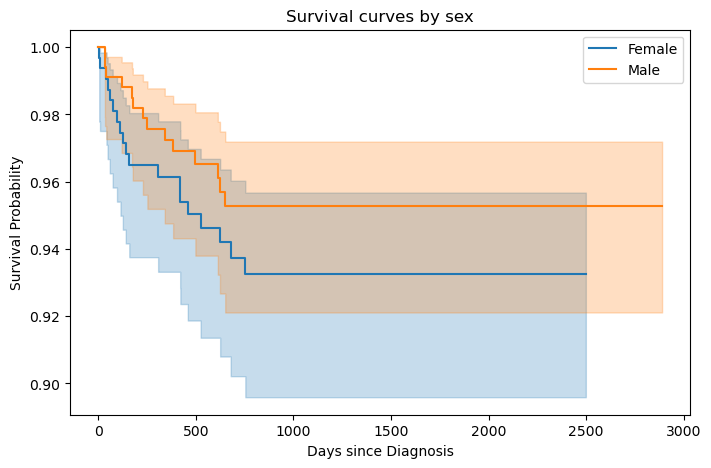

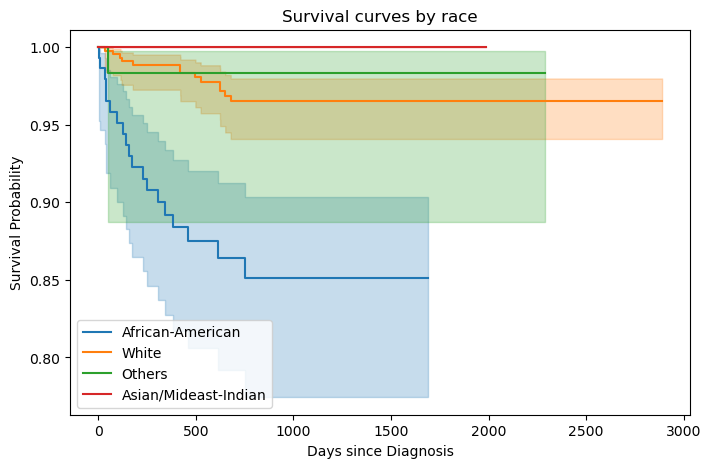

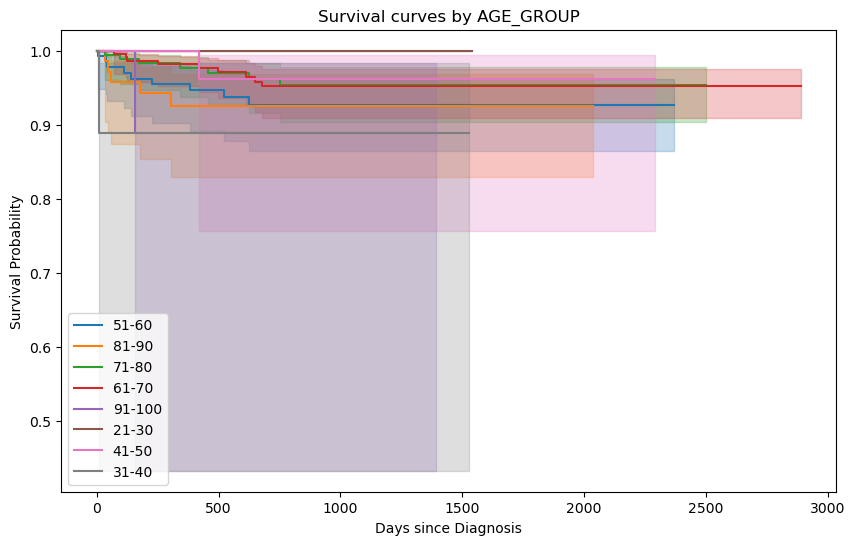

In [520]:
# Survival curves by gender
plt.figure(figsize=(8,5))
plot_survival(pancreas_df, 'sex')
plt.show()

# Survival curves by race
plt.figure(figsize=(8,5))
plot_survival(pancreas_df, 'race')
plt.show()

# Try plotting again
plt.figure(figsize=(10, 6))
plot_survival(pancreas_df, 'AGE_GROUP')
plt.show()

#### THYROID

In [521]:
print(thyroid_df.shape)
thyroid_df.head()

(744, 11)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,status,num_cancers,THYROID,THYROID_DT,AGE_AT_DIAGNOSIS,AGE_GROUP,DURATION
6,1946-11-03,NaT,Female,African-American,0,1,1,2012-11-29,66,61-70,1365
7,1938-06-10,NaT,Female,African-American,0,1,1,2012-06-24,74,71-80,1523
28,1948-02-17,NaT,Female,African-American,0,1,1,2012-09-02,64,61-70,1453
32,1949-09-04,NaT,Female,White,0,1,1,2014-03-19,64,61-70,890
98,1949-12-15,NaT,Female,African-American,0,1,1,2013-02-26,63,61-70,1276


In [522]:
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 6 to 8463
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    744 non-null    datetime64[ns]
 1   DEATH_DATE_off    8 non-null      datetime64[ns]
 2   sex               744 non-null    object        
 3   race              744 non-null    object        
 4   status            744 non-null    int64         
 5   num_cancers       744 non-null    int64         
 6   THYROID           744 non-null    int64         
 7   THYROID_DT        744 non-null    datetime64[ns]
 8   AGE_AT_DIAGNOSIS  744 non-null    int64         
 9   AGE_GROUP         744 non-null    category      
 10  DURATION          744 non-null    int64         
dtypes: category(1), datetime64[ns](3), int64(5), object(2)
memory usage: 65.0+ KB


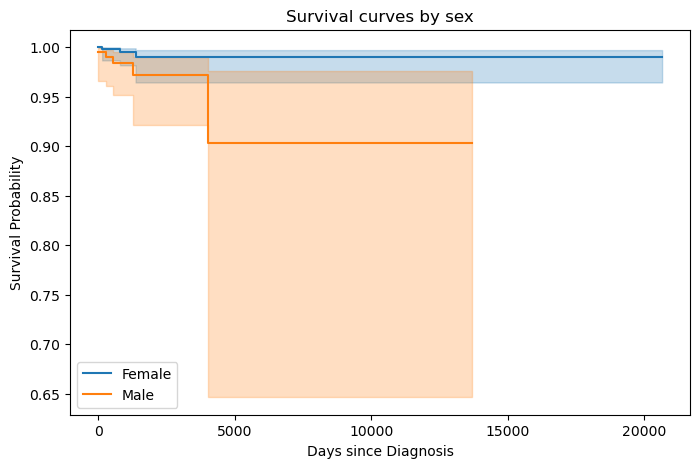

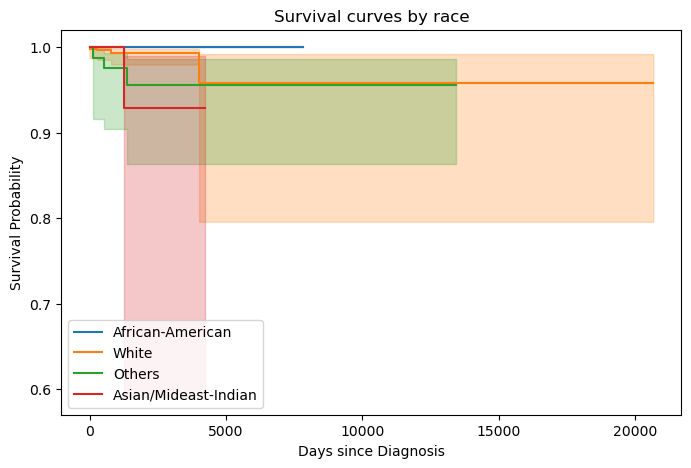

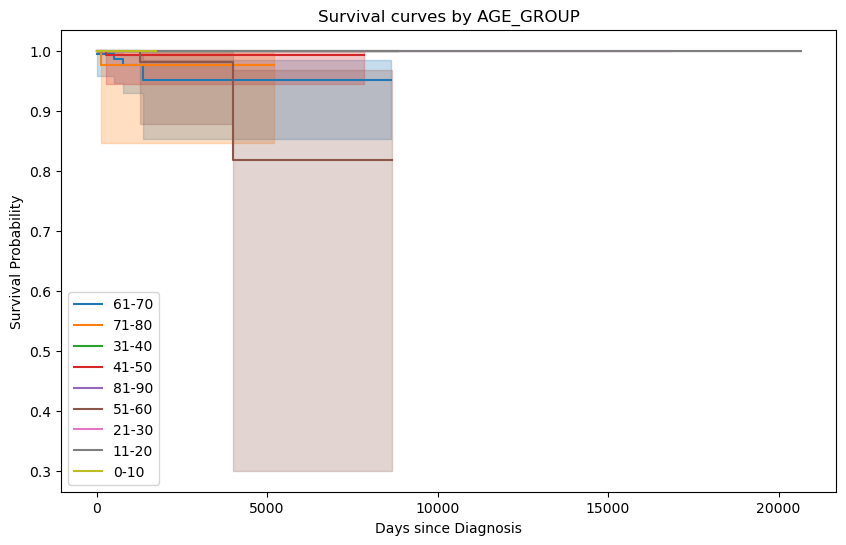

In [523]:
# Survival curves by gender
plt.figure(figsize=(8,5))
plot_survival(thyroid_df, 'sex')
plt.show()

# Survival curves by race
plt.figure(figsize=(8,5))
plot_survival(thyroid_df, 'race')
plt.show()

# Try plotting again
plt.figure(figsize=(10, 6))
plot_survival(thyroid_df, 'AGE_GROUP')
plt.show()

#### COLORECTAL

In [524]:
print(colorectal_df.shape)
colorectal_df.head()

(946, 11)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,status,num_cancers,COLORECTAL,COLORECTAL_DT,AGE_AT_DIAGNOSIS,AGE_GROUP,DURATION
13,1971-08-11,NaT,Female,African-American,0,1,1,2014-01-01,42,41-50,967
14,1948-03-22,2016-01-07,Female,African-American,1,1,1,2014-09-30,66,61-70,464
16,1946-01-09,NaT,Female,African-American,0,1,1,2013-09-14,67,61-70,1076
36,1970-12-19,NaT,Female,White,0,1,1,2013-12-09,42,41-50,990
41,1928-03-25,NaT,Female,African-American,0,2,1,2013-12-11,85,81-90,988


In [525]:
colorectal_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946 entries, 13 to 8452
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    946 non-null    datetime64[ns]
 1   DEATH_DATE_off    64 non-null     datetime64[ns]
 2   sex               946 non-null    object        
 3   race              946 non-null    object        
 4   status            946 non-null    int64         
 5   num_cancers       946 non-null    int64         
 6   COLORECTAL        946 non-null    int64         
 7   COLORECTAL_DT     946 non-null    datetime64[ns]
 8   AGE_AT_DIAGNOSIS  946 non-null    int64         
 9   AGE_GROUP         946 non-null    category      
 10  DURATION          946 non-null    int64         
dtypes: category(1), datetime64[ns](3), int64(5), object(2)
memory usage: 82.6+ KB


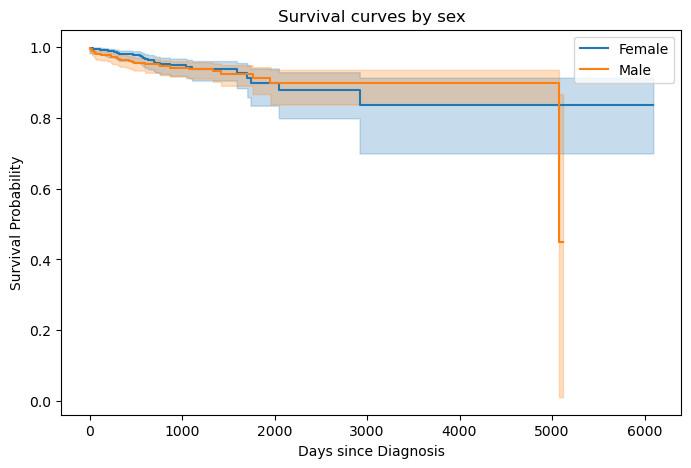

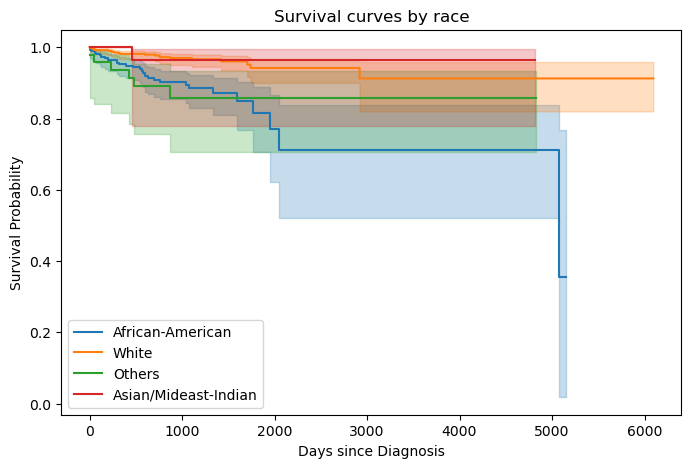

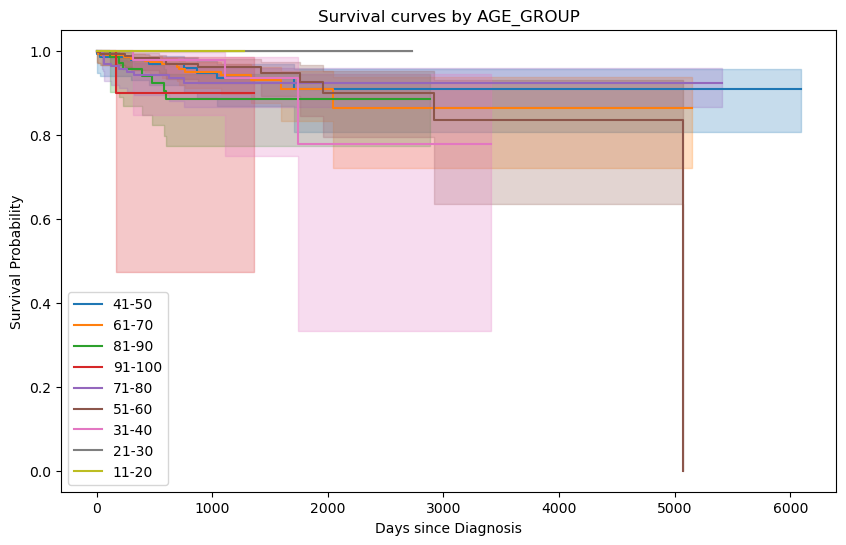

In [526]:
# Survival curves by gender
plt.figure(figsize=(8,5))
plot_survival(colorectal_df, 'sex')
plt.show()

# Survival curves by race
plt.figure(figsize=(8,5))
plot_survival(colorectal_df, 'race')
plt.show()

# Try plotting again
plt.figure(figsize=(10, 6))
plot_survival(colorectal_df, 'AGE_GROUP')
plt.show()

#### MELANOMA

In [527]:
print(melanoma_df.shape)
melanoma_df.head()

(346, 11)


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,status,num_cancers,MELANOMA,MELANOMA_DT,AGE_AT_DIAGNOSIS,AGE_GROUP,DURATION
146,1928-06-22,NaT,Male,White,0,1,1,2015-03-03,86,81-90,541
178,1933-12-27,2014-11-27,Male,White,1,1,1,2012-12-20,78,71-80,707
196,1924-04-08,NaT,Female,White,0,1,1,2014-05-31,90,91-100,817
341,1957-10-04,NaT,Female,White,0,1,1,2013-05-19,55,51-60,1194
354,1966-08-03,NaT,Male,White,0,1,1,2015-03-09,48,41-50,535


In [528]:
melanoma_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346 entries, 146 to 8467
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BIRTH_DATE_off    346 non-null    datetime64[ns]
 1   DEATH_DATE_off    18 non-null     datetime64[ns]
 2   sex               346 non-null    object        
 3   race              346 non-null    object        
 4   status            346 non-null    int64         
 5   num_cancers       346 non-null    int64         
 6   MELANOMA          346 non-null    int64         
 7   MELANOMA_DT       346 non-null    datetime64[ns]
 8   AGE_AT_DIAGNOSIS  346 non-null    int64         
 9   AGE_GROUP         346 non-null    category      
 10  DURATION          346 non-null    int64         
dtypes: category(1), datetime64[ns](3), int64(5), object(2)
memory usage: 30.5+ KB


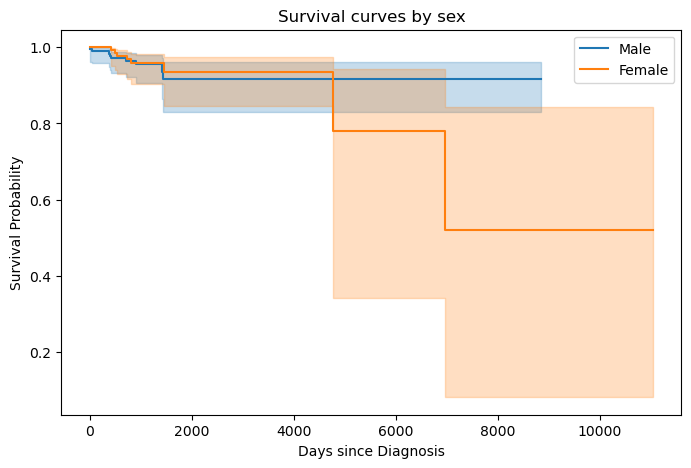

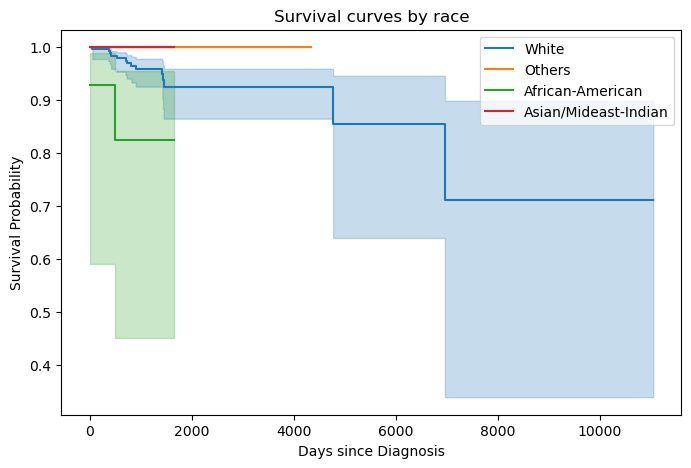

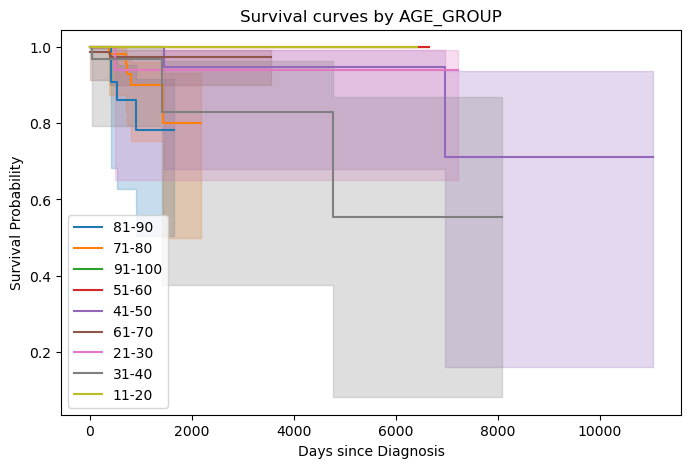

In [529]:
# Survival curves by gender
plt.figure(figsize=(8,5))
plot_survival(melanoma_df, 'sex')
plt.show()

# Survival curves by race
plt.figure(figsize=(8,5))
plot_survival(melanoma_df, 'race')
plt.show()

# Try plotting again
plt.figure(figsize=(8,5))
plot_survival(melanoma_df, 'AGE_GROUP')
plt.show()

In [530]:
# Combine all DataFrames into one DataFrame with an additional 'cancer_type' column
combined_cancer_df = pd.concat(cancer_df, names=['cancer_type']).reset_index(level=0)

In [531]:
pairwise_results = pairwise_logrank_test(event_durations=combined_cancer_df['DURATION'], 
                                         groups=combined_cancer_df['cancer_type'], 
                                         event_observed=combined_cancer_df['status'])

# Print pairwise comparison results
pairwise_summary = pairwise_results.summary
print(pairwise_summary)

                     test_statistic             p   -log2(p)
COLORECTAL LUNG           31.193663  2.335271e-08  25.351835
           MELANOMA        1.608241  2.047393e-01   2.288140
           PANCREAS        0.042741  8.362128e-01   0.258058
           THYROID        30.688902  3.028926e-08  24.976619
LUNG       MELANOMA       21.285341  3.957462e-06  17.946993
           PANCREAS       24.335197  8.094642e-07  20.236529
           THYROID        87.819133  7.172180e-21  66.918078
MELANOMA   PANCREAS        0.546581  4.597180e-01   1.121179
           THYROID        15.636980  7.673912e-05  13.669678
PANCREAS   THYROID        23.126039  1.517221e-06  19.330137


In [532]:
def compare_survival_at_fixed_timepoint(cancer_dfs):
    survival_stats = {}
    for cancer_type, df in cancer_dfs.items():
        kmf = KaplanMeierFitter()
        kmf.fit(df['DURATION'], event_observed=df['status'])
        survival_probability = kmf.predict((end_date - pd.to_datetime(df['DURATION'].max())).days)
        survival_stats[cancer_type] = survival_probability.round(4)
    return survival_stats

In [533]:
compare_survival_at_fixed_timepoint(cancer_df)

{'LUNG': 0.0,
 'PANCREAS': 0.943,
 'THYROID': 0.955,
 'COLORECTAL': 0.7443,
 'MELANOMA': 0.7119}

### Questions:

##### 1. Which cancer has the highest survival for this cohort?

Thyroid has the highest survival for this cohort

##### 2. which cancer has the lowest survival for this cohort?

Lung is the cancer with the lowest survival for this cohort.

##### 3. How many patients had 2 cancer diagnosis?

In [534]:
two_cancers_diag = df2[df2['num_cancers'] == 2]
print(f'There are {len(two_cancers_diag)} patients diagnosed with 2 cancers')
two_cancers_diag.head()

There are 29 patients diagnosed with 2 cancers


,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG_DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,status,num_cancers
41,1928-03-25,NaT,Female,African-American,1,0,0,1,0,2012-02-22,NaT,NaT,2013-12-11,NaT,0,2
164,1924-11-30,NaT,Female,African-American,1,0,0,1,0,2013-02-04,NaT,NaT,2013-01-14,NaT,0,2
308,1954-04-20,NaT,Female,African-American,0,0,1,1,0,NaT,NaT,2015-05-06,2010-12-04,NaT,0,2
557,1942-11-10,NaT,Female,White,1,0,0,1,0,2013-09-14,NaT,NaT,2013-08-16,NaT,0,2
611,1955-03-23,NaT,Male,White,0,1,0,0,1,NaT,2014-02-14,NaT,NaT,2013-12-13,0,2


##### 4. which age group has the lowest survival after 400 days since cancer diagnosis?

In [535]:
combined_cancer_df.columns

Index(['cancer_type', 'BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race',
       'status', 'num_cancers', 'LUNG', 'LUNG_DT', 'AGE_AT_DIAGNOSIS',
       'AGE_GROUP', 'DURATION', 'PANCREAS', 'PANCREAS_DT', 'THYROID',
       'THYROID_DT', 'COLORECTAL', 'COLORECTAL_DT', 'MELANOMA', 'MELANOMA_DT'],
      dtype='object')

In [536]:
# Then calculate survival rate after 400 days for each age group across all cancers
age_groups = combined_cancer_df['AGE_GROUP'].unique()
survival_rates = {}
for age_group in age_groups:
    survival_rate = calculate_survival(combined_cancer_df, 'AGE_GROUP', age_group, 400)
    survival_rates[age_group] = survival_rate

# Find the age group with the lowest survival
lowest_survival_age_group = min(survival_rates, key=survival_rates.get)
print(f'The age group has the lowest survival after 400 days since cancer diagnosis is {lowest_survival_age_group} group')


The age group has the lowest survival after 400 days since cancer diagnosis is >100 group


##### 5. what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [537]:
result_5 = calculate_survival(colorectal_df, 'sex', 'Female', 1000)
print(f'Survival Rate for females with colorectal cancer after 1000 days since diagnosis is {result_5.round(4)*100}%')

Survival Rate for females with colorectal cancer after 1000 days since diagnosis is 94.84%


##### 6. what is the survival rate for males with lung cancer after 300 days since diagnosis?

In [538]:
result_6 = calculate_survival(lung_df, 'sex', 'Male', 300)
print(f'Survival Rate for males with lung cancer after 300 days since diagnosis is {result_6.round(4)*100}%')

Survival Rate for males with lung cancer after 300 days since diagnosis is 91.5%


##### 7. what is the survival rate for females with melanoma cancer after 1200 days since diagnosis?

In [539]:
result_7 = calculate_survival(melanoma_df, 'sex', 'Female', 1200)
print(f'Survival Rate for females with melanoma cancer after 1200 days since diagnosis is {result_7.round(4)*100}%')

Survival Rate for females with melanoma cancer after 1200 days since diagnosis is 95.88%


##### 8. what is the survival rate for males with thyroid cancer after 1500 days since diagnosis?

In [540]:
result_8 = calculate_survival(thyroid_df, 'sex', 'Male', 1500)
print(f'Survival Rate for males with thyroid cancer after 1500 days since diagnosis is {result_8.round(4)*100}%')

Survival Rate for males with thyroid cancer after 1500 days since diagnosis is 97.23%


##### 9. what is the survival rate for males with pancreatic cancer after 2200 days since diagnosis?

In [541]:
result_9 = calculate_survival(pancreas_df, 'sex', 'Male', 2200)
print(f'Survival Rate for males with pancreatic cancer after 2200 days since diagnosis {result_9.round(4)*100}%')

Survival Rate for males with pancreatic cancer after 2200 days since diagnosis 95.28%


##### 10. what is the survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis?

In [542]:
colorectal_df.race.value_counts()

race
White                   606
African-American        263
Others                   47
Asian/Mideast-Indian     30
Name: count, dtype: int64

In [543]:
result_10 = calculate_survival(colorectal_df, 'race', 'African-American', 2000)
print(f'Survival Rate for the African-Americans with colorectal cancer after 2200 days since diagnosis is {result_10.round(4)*100}%')

Survival Rate for the African-Americans with colorectal cancer after 2200 days since diagnosis is 77.07000000000001%


##### 11. what is the survival rate for Whites with lung cancer after 1000 days since diagnosis?

In [544]:
result_11 = calculate_survival(lung_df, 'race', 'White', 1000)
print(f'Survival Rate for the Whites with lung cancer after 1000 days since diagnosis is {result_11.round(4)*100}%')

Survival Rate for the Whites with lung cancer after 1000 days since diagnosis is 90.93%


##### 12. what is the survival rate for African-Americans with melanoma cancer after 2 years since diagnosis?

In [545]:
result_12 = calculate_survival(melanoma_df, 'race', 'African-American', 365*2)
print(f'Survival Rate for the African-Americans with melanoma cancer after 2 years since diagnosis is {result_12.round(4)*100}%')

Survival Rate for the African-Americans with melanoma cancer after 2 years since diagnosis is 82.54%


##### 13. what is the survival rate for Whites with pancreatic cancer after 3 years since diagnosis?

In [546]:
result_13 = calculate_survival(pancreas_df, 'race', 'White', 365*3)
print(f'Survival Rate for the Whites with pancreatic cancer after 3 years since diagnosis is {result_13.round(4)*100}%')

Survival Rate for the Whites with pancreatic cancer after 3 years since diagnosis is 96.54%


##### 14. what is the survival rate for Asians with thyroid cancer after 1500 days since diagnosis?

In [547]:
result_14 = calculate_survival(thyroid_df, 'race', 'Asian/Mideast-Indian', 1500)
print(f'Survival Rate for the Asians with thyroid cancer after 1500 days since diagnosis is {result_14.round(4)*100}%')

Survival Rate for the Asians with thyroid cancer after 1500 days since diagnosis is 92.86%


##### 15. which age group has the lowest survival for colorectal cancer at the end of the study?

In [548]:
# Then calculate survival rate after 400 days for each age group across all cancers
colorectal_survival_rates = {}
for age in colorectal_df['AGE_GROUP'].unique():
    age_groups = colorectal_df[colorectal_df["AGE_GROUP"] == age]
    kmf.fit(age_groups['DURATION'], event_observed=age_groups['status'])

    survival_rate = kmf.predict((end_date - pd.to_datetime(age_groups['DURATION'].min())).days)

    colorectal_survival_rates[age] = survival_rate

# Find the age group with the lowest survival
lowest_colorectal_survival_age_group = min(colorectal_survival_rates, key=colorectal_survival_rates.get)
print(f'The age group has the lowest survival for colorectal cancer at the end of the study is {lowest_colorectal_survival_age_group} group')

The age group has the lowest survival for colorectal cancer at the end of the study is 51-60 group


##### 16. which age group has the highest survival for lung cancer at the end of the study?

In [549]:
# Then calculate survival rate after 400 days for each age group across all cancers
lung_survival_rates = {}
for age_group in lung_df['AGE_GROUP'].unique():
    age_groups = lung_df[lung_df["AGE_GROUP"] == age_group]
    kmf.fit(age_groups['DURATION'], event_observed = age_groups['status'])

    survival_rate = kmf.predict((end_date - pd.to_datetime(age_groups['DURATION'].min())).days)

    lung_survival_rates[age_group] = survival_rate

# Find the age group with the lowest survival
highest_lung_survival_age_group = max(lung_survival_rates, key=lung_survival_rates.get)
print(f'The age group has the highest survival for lung cancer at the end of the study is {highest_lung_survival_age_group} group')

The age group has the highest survival for lung cancer at the end of the study is 21-30 group


##### 17. what is the survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis?

In [550]:
melanoma_df.AGE_GROUP.value_counts()

AGE_GROUP
61-70     79
51-60     69
71-80     60
41-50     54
31-40     31
81-90     25
21-30     20
11-20      4
91-100     4
0-10       0
>100       0
Name: count, dtype: int64

In [551]:
result_17 = calculate_survival(melanoma_df, 'AGE_GROUP', '61-70', 365*5)
print(f'Survival Rate for for 61-70 age group with melanoma cancer after 5 years since diagnosis is {result_17.round(4)*100}%')

Survival Rate for for 61-70 age group with melanoma cancer after 5 years since diagnosis is 97.39999999999999%


##### 18. what is the survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis?

In [552]:
pancreas_df.AGE_GROUP.value_counts()

AGE_GROUP
61-70     222
71-80     178
51-60     135
81-90      72
41-50      30
31-40       9
91-100      9
21-30       3
0-10        0
11-20       0
>100        0
Name: count, dtype: int64

In [553]:
result_18 = calculate_survival(pancreas_df, 'AGE_GROUP', '21-30', 365)
print(f'Survival Rate for 21-30 age group with pancreatic cancer after a year since diagnosis is {result_18.round(4)*100}%')

Survival Rate for 21-30 age group with pancreatic cancer after a year since diagnosis is 100.0%


##### 19. what is the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis?

In [554]:
thyroid_df.AGE_GROUP.value_counts()

AGE_GROUP
61-70     168
51-60     165
41-50     130
31-40     121
21-30      67
71-80      44
11-20      34
81-90      10
0-10        5
91-100      0
>100        0
Name: count, dtype: int64

In [555]:
result_19 = calculate_survival(thyroid_df, 'AGE_GROUP', '51-60', 2200)
print(f'Survival Rate the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis is {result_19.round(4)*100}%')

Survival Rate the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis is 98.18%


##### 20. which race has the high survival for all cancers after 2500 days since diagnosis?

In [556]:
races = combined_cancer_df['race'].unique()
race_survival_rates = {}
for r in races:
    survival_rate = calculate_survival(combined_cancer_df, 'race', r, 2500)
    race_survival_rates[r] = survival_rate

# Find the age group with the lowest survival
highest_survival_race = max(race_survival_rates, key=race_survival_rates.get)
print(f'The race has the high survival for all cancers after 2500 days since diagnosis is {highest_survival_race} group')


The race has the high survival for all cancers after 2500 days since diagnosis is White group
